# Ham or Spam

<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

df = pd.read_csv('emails.csv')

df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


<hr>

## Data Preprocessing

#### Splitting the dataset

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.spam, test_size=0.3, random_state=0)

In [4]:
X_train.shape

(4009,)

#### Extracting features from text files

Emails are actually `series of words` (ordered). In order to run machine learning algorithms we need to convert the text of email into `numerical feature vectors`. 

We have used the `bag of words` model for our example. 

Briefly, we segment each email into words (for English splitting by space), and **`count number of times each word occurs in each document and finally assign each word an integer id`**. Each unique word in our dictionary will correspond to a feature (descriptive feature).

`Scikit-learn` has a high level component `CountVectorizer` which will create feature vectors.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)

X_train_counts.shape

(4009, 31949)

**`TF:`** 
    
Just counting the number of words in each email has 1 issue: it will give more weightage to longer emails than shorter emails. To avoid this, we can use frequency **`(TF - Term Frequencies)`** i.e. **`#count(word) / #Total words`**, in each email.

**`TF-IDF:`** 

Finally, we have reduce the weightage of more common words like `(the, is, an etc.)` which occurs in all email. This is called as **`TF-IDF i.e Term Frequency times inverse document frequency.`**

To achieve this `TfidfTransformer`from `Scikit-learn` is used.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_train_tfidf.shape

(4009, 31949)

<hr>

## Creating the model

In [7]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

#### Cross Validation

In [8]:
from sklearn.naive_bayes import MultinomialNB

score = cross_val_score(MultinomialNB(), X_train_tfidf, y_train, cv=skf)
score.mean()

0.8613167082294264

#### Parameter Tuning

In [9]:
parameters = {
    'alpha': (1e-2, 1e-3)
}

gs_nb = GridSearchCV(MultinomialNB(), parameters, cv=skf, n_jobs=-1)
gs_nb = gs_nb.fit(X_train_tfidf, y_train)

In [10]:
print(gs_nb.best_score_)
print(gs_nb.best_params_)

0.9925174563591022
{'alpha': 0.01}


#### Pipeline

In [11]:
from sklearn.pipeline import Pipeline

In [12]:
model_nb = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))
            ])

In [13]:
# Parameter Tuning

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3)
}

gs_nb = GridSearchCV(model_nb, parameters, n_jobs=-1)
gs_nb = gs_nb.fit(X_train, y_train)

In [14]:
print(gs_nb.best_score_)
print(gs_nb.best_params_)

0.991021198564139
{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


#### Fitting the model

In [15]:
gs_nb.fit(X_train, y_train);
# Semi-colon at the end to not to print the output

#### Prediction

In [16]:
y_test_pred = gs_nb.predict(X_test)

#### Evaluating the model

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [18]:
# Metrics

print(f'Model Score: {gs_nb.score(X_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9912739965095986
f1-score: 0.9912243072033654
precision score: 0.9913344899384374
recall score: 0.9912739965095986


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1314
           1       1.00      0.97      0.98       405

    accuracy                           0.99      1719
   macro avg       0.99      0.98      0.99      1719
weighted avg       0.99      0.99      0.99      1719

Confusion matrix, without normalization
[[1313    1]
 [  14  391]]


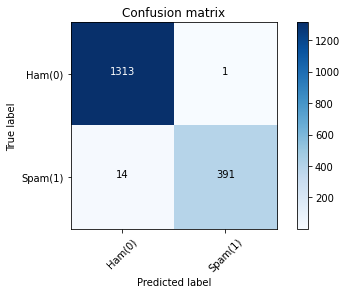

In [20]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(y_test, y_test_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Ham(0)', 'Spam(1)'],normalize= False,  title='Confusion matrix')

#### Saving the model

In [21]:
from joblib import dump

dump(gs_nb, 'model.joblib')

['model.joblib']

<hr>